# Simple hovercraft motion planning examples

In [1]:
import gurobipy as gp
from gurobipy import GRB
import math
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# continuous dynamics
A = np.r_[
    np.c_[np.zeros((2, 2)), np.eye(2)],
    np.c_[np.zeros((2, 2)), np.zeros((2, 2))]
]
B = np.r_[np.zeros((2, 2)), np.eye(2)]
n = np.shape(A)[0]
m = np.shape(B)[1]

# convert to discrete
dt = 1
A = np.eye(n) + dt * A
B = dt * B

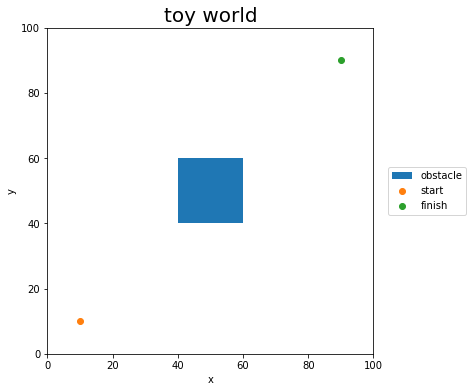

In [3]:
# visualize map
def create_figure(title="", traj=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.fill_between([40, 60], [40, 40], [60, 60], label="obstacle")
    ax.set_aspect(1)
    ax.scatter(10, 10, label="start")
    ax.scatter(90, 90, label="finish")
    ax.set_xlim((0, 100))
    ax.set_ylim((0, 100))
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title, fontsize=20)
    if traj is not None:
        for i in range(traj.shape[0]):
            ax.plot(x_opt[i, 0, :], x_opt[i, 1, :], color=np.random.rand(3),
                    label="vehicle {}".format(i+1), linewidth=3)
    ax.legend(loc='center right', bbox_to_anchor=(1.3, .5))
    return fig, ax

fig, ax = create_figure(title="toy world")

# Motion planning via MIP

In [4]:
# create problem variables

def opt_vars(grb_model, n_vehicles, state_dim, control_dim, horizon):
    model = grb_model
    N, n, m, H = n_vehicles, state_dim, control_dim, horizon
    # state
    x = model.addMVar((N, n, H), lb=-float('inf'), vtype=GRB.CONTINUOUS, name="x")
    # control
    u = model.addMVar((N, m, H-1), lb=-float('inf'), vtype=GRB.CONTINUOUS)
    return x, u

def constraint_sat_vars(grb_model, n_vehicles, n_constraints, horizon):
    model = grb_model
    N, p, H = n_vehicles, n_constraints, horizon 
    # obstacle avoidance
    z = model.addMVar((N, p, H), vtype=GRB.BINARY)
    # other vehicle avoidance
    if N > 1:
        w = model.addMVar((N, N, H, n), vtype=GRB.BINARY)
        return z, w
    return z, None

In [5]:
# constraints

# box constraints
def box_constraints(grb_model, n_vehicles, horizon):
    model = grb_model
    N, H = n_vehicles, horizon
    for i in range(N):
        for k in range(H):
            model.addConstr(x[i, :, k] >= x_min)
            model.addConstr(x[i, :, k] <= x_max)
    for i in range(N):
        for k in range(H-1):
            model.addConstr(u[i, :, k] >= u_min)
            model.addConstr(u[i, :, k] <= u_max)

# start and end configurations
def start_end_constrs(grb_model, n_vehicles, state_dim, end_dist=0, end_close=False):
    model = grb_model
    N, n = n_vehicles, state_dim
    for i in range(N):
        model.addConstr(x[i, :, 0] == x_start[i, :])
        if end_close:
            model.addConstr(sum((x[i, j, -1] - x_stop[j])**2 for j in range(2)) <= end_dist**2)
            model.addConstr(x[i, 2:, -1] == x_stop[2:])
        else:
            model.addConstr(x[i, :, -1] == x_stop)

# dynamics constraints
def dynamics_constrs(grb_model, n_vehicles, horizon, state_dim, ctrl_dim, A, B):
    model = grb_model
    N, H, n, m = n_vehicles, horizon, state_dim, ctrl_dim
    for i in range(N):
        for k in range(H-1):
            model.addConstr(A @ x[i, :, k] + B @ u[i, :, k] == x[i, :, k+1])

def obstacle_constrs(grb_model, n_vehicles, horizon, A_con, b_con):
    model = grb_model
    N, H = n_vehicles, horizon
    for i in range(N):
        for k in range(H):
            model.addConstr(A_con @ x[i, 0:2, k] - b_con <= (1 - z[i, :, k]) * M)
            model.addConstr(z[i, :, k].sum() >= 1)

def veh_avoid_constrs(grb_model, n_vehicles, horizon):
    model = grb_model
    N, H = n_vehicles, horizon
    for i in range(N):
        for j in range(i+1, N):
            for k in range(H):
                model.addConstr(x[i, 0, k] - x[j, 0, k] >= x_safe - (1 - w[i, j, k, 0]) * M)
                model.addConstr(x[j, 0, k] - x[i, 0, k] >= x_safe - (1 - w[i, j, k, 1]) * M)
                model.addConstr(x[i, 1, k] - x[j, 1, k] >= y_safe - (1 - w[i, j, k, 2]) * M)
                model.addConstr(x[j, 1, k] - x[i, 1, k] >= y_safe - (1 - w[i, j, k, 3]) * M)
                model.addConstr(w[i, j, k, :].sum() >= 1)

def convoy_constr(grb_model, n_vehicles, horizon):
    model = grb_model
    N, H = n_vehicles, horizon
    for i in range(N):
        for j in range(i+1, N):
            for k in range(H):
                model.addConstr((x[i, 0, k] - x[j, 0, k])**2 + 
                                (x[i, 1, k] - x[j, 1, k])**2 <= max_dist**2)

In [6]:
# box constraints on variables
x_min = np.array([0, 0, -2, -2])
x_max = np.array([100, 100, 2, 2])
u_min = np.array([-1, -1])
u_max = np.array([1, 1])

# start and stop values
x_start = np.array([[10, 10, 0, 0]])
x_stop  = np.array([90, 90, 0, 0])
max_final_dist = 0

# obstacle halfspace parameters
a_1 = np.array([0, 1])  ; b_1 = 40
a_2 = np.array([0, -1]) ; b_2 = -60
a_3 = np.array([1, 0])  ; b_3 = 40
a_4 = np.array([-1, 0]) ; b_4 = -60
A_con = np.array([a_1, a_2, a_3, a_4])
b_con = np.array([40, -60, 40, -60])

M = 100  # large number for big M trick

# safe distances for avoiding one another
x_safe = 5
y_safe = 5

# convoy constraint
max_dist = 10

# time horizon
T = 100
H = round(T / dt)

N = 1 # number of vehicles

In [7]:
# set up gurobi optimization model
model = gp.Model(name="simple MIQP motion planning")
model.Params.OutputFlag = 0
model.Params.DualReductions = 0

Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-05


In [8]:
x, u = opt_vars(model, N, n, m, H)
z, w = constraint_sat_vars(model, N, A.shape[0], H)
print("Number of state continuous variables:", math.prod(x.shape))
print("Number of control continuous variables:", math.prod(u.shape))
print("Number of obstacle collision avoidance binary variables:", 
      math.prod(z.shape))
if N > 1:
    print("Number of vehicle collision avoidance binary variables:", 
          math.prod(w.shape))

Number of state continuous variables: 400
Number of control continuous variables: 198
Number of obstacle collision avoidance binary variables: 400


In [9]:
box_constraints(model, N, H)
start_end_constrs(model, N, n)
dynamics_constrs(model, N, H, n, m, A, B)
obstacle_constrs(model, N, H, A_con, b_con)
veh_avoid_constrs(model, N, H)
convoy_constr(model, N, H)

In [10]:
obj = sum(u[i, :, k] @ u[i, :, k] for i in range(N) for k in range(H-1))
model.setObjective(obj, GRB.MINIMIZE)

start = time.time()
model.optimize()
end = time.time()

print("Execution time:", end - start)
print("Optimization status:", model.Status)
print("Objective value:", obj.getValue().item())

Execution time: 0.09697675704956055
Optimization status: 2
Objective value: 0.19339857897092294


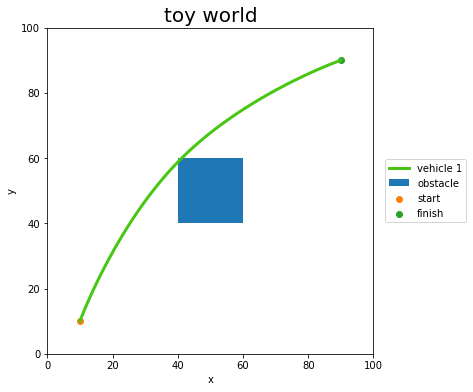

In [11]:
x_opt = x.X
fig, ax = create_figure(title="toy world", traj=x_opt)

## Multi-vehicle motion planning via MIP

In [12]:
# use multiple vehicles
N = 2
H = 100
x_start = np.array([[5, 10, 0, 0], [10, 10, 0, 0]])
max_final_dist = 5

In [13]:
# set up gurobi optimization model
model = gp.Model(name="multi-vehicle MIQP motion planning")
model.Params.OutputFlag = 0

In [14]:
x, u = opt_vars(model, N, n, m, H)
z, w = constraint_sat_vars(model, N, A.shape[0], H)
print("Number of state continuous variables:", math.prod(x.shape))
print("Number of control continuous variables:", math.prod(u.shape))
print("Number of obstacle collision avoidance binary variables:", 
      math.prod(z.shape))
if N > 1:
    print("Number of vehicle collision avoidance binary variables:", 
          math.prod(w.shape))

Number of state continuous variables: 800
Number of control continuous variables: 396
Number of obstacle collision avoidance binary variables: 800
Number of vehicle collision avoidance binary variables: 1600


In [15]:
box_constraints(model, N, H)
start_end_constrs(model, N, n, end_dist=max_final_dist, end_close=True)
dynamics_constrs(model, N, H, n, m, A, B)
obstacle_constrs(model, N, H, A_con, b_con)
veh_avoid_constrs(model, N, H)
convoy_constr(model, N, H)

In [16]:
obj = sum(u[i, :, k] @ u[i, :, k] for i in range(N) for k in range(H-1))
model.setObjective(obj, GRB.MINIMIZE)

start = time.time()
model.optimize()
end = time.time()

print("Execution time:", end - start)
print("Optimization status:", model.Status)
print("Objective value:", obj.getValue().item())

Execution time: 30.896804571151733
Optimization status: 2
Objective value: 0.35966908710288464


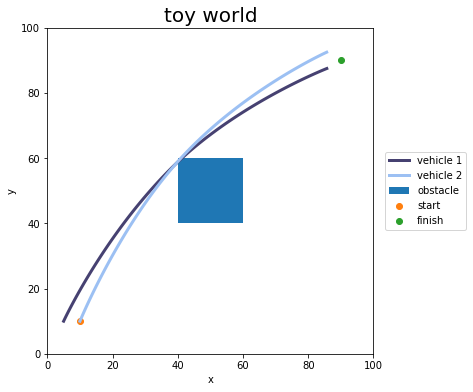

In [17]:
x_opt = x.X
fig, ax = create_figure(title="toy world", traj=x_opt)